In [2]:
from sklearn import svm
from sklearn.datasets import samples_generator
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline

In [3]:
X, y = samples_generator.make_classification(n_informative=5, n_redundant=0, random_state=42)
anova_filter = SelectKBest(f_regression, k=5)
clf = svm.SVC(kernel='linear')
anova_svm = Pipeline([('anova', anova_filter), ('svc', clf)])
# You can set the parameters using the names issued
# For instance, fit using a k of 10 in the SelectKBest
# and a parameter 'C' of the svm
anova_svm.set_params(anova__k=10, svc__C=.1).fit(X, y)

Pipeline(steps=[('anova', SelectKBest(k=10, score_func=<function f_regression at 0x10faf76a8>)), ('svc', SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [4]:
prediction = anova_svm.predict(X)
anova_svm.score(X, y)

0.82999999999999996

In [5]:
# getting the selected features chosen by anova_filter
anova_svm.named_steps['anova'].get_support()

array([False, False,  True,  True, False, False,  True,  True, False,
        True, False,  True,  True, False,  True, False,  True,  True,
       False, False], dtype=bool)

In [6]:
############################################
# Illustration of Pipeline and GridSearchCV
############################################
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2

In [7]:
print(__doc__)
# feature selection and classifier
pipe = Pipeline([
    ('reduce_dim', PCA()),
    ('classify', LinearSVC())
])


Automatically created module for IPython interactive environment


In [8]:
############################################
# set up param_grid for two different feature selection algorithm
# 1. PCA
# 2. SelectKBest
############################################
N_FEATURES_OPTIONS = [2, 4, 8]
C_OPTIONS = [1, 10, 100, 1000]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest(chi2)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
]

In [9]:
reducer_labels = ['PCA', 'NMF', 'KBest(chi2)']

In [10]:
grid = GridSearchCV(pipe, cv=3, n_jobs=1, param_grid=param_grid)
digits = load_digits()
grid.fit(digits.data, digits.target)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'reduce_dim': [PCA(copy=True, iterated_power=7, n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), NMF(alpha=0.0, beta=1, eta=0.1, init=None, l1_ratio=0.0, max_iter=200,
  n_components=8, nls_max_iter=2000, random_state=None, shuffle=False,
  solver='cd', sp...nc=<function chi2 at 0x10faf7620>)], 'reduce_dim__k': [2, 4, 8], 'classify__C': [1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

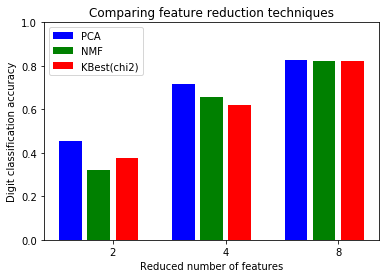

In [11]:
mean_scores = np.array(grid.cv_results_['mean_test_score'])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
# select score for best C
mean_scores = mean_scores.max(axis=0)
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (len(reducer_labels) + 1) + .5)

plt.figure()
COLORS = 'bgrcmyk'
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("Comparing feature reduction techniques")
plt.xlabel('Reduced number of features')
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel('Digit classification accuracy')
plt.ylim((0, 1))
plt.legend(loc='upper left')
plt.show()